# Tutorial: phase I approval prediction

In this tutorial, we show how to predict clinical trial Phase I approval step by step. 

Agenda:

- Part I: Import modules
- Part II: Specify task
- Part III: Pretraining 
- Part IV: Data loader
- Part V: Raw data embedding
- Part VI: Learn and inference

Let's start!

## 1. Import modules

It includes 

- Standard modules, e.g., ```PyTorch```. 
- self-defined module, e.g., ```dataloader```, ```model```. 

We also specify the device (**CPU or GPU**) using ```device = torch.device("cpu")``` or ```device = torch.device("cuda:0")```.

In [1]:
import torch, os
torch.manual_seed(0) 
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst, csv_three_feature_2_complete_dataloader
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cpu")  ## cuda:0

## 2. Specify task
The task includes:  
- phase I prediction
- validation data file 
- test data file

In [2]:
base_name = 'phase_I' 
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

## 3. Pretrain

ADMET stands for 
- Absorption 
- Distribution
- Metabolism
- Excretion 
- Toxicity 

The prediction of the ADMET properties plays an important role in the drug design process because these properties account for the failure of about 60% of all drugs in the clinical phases.

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

## 4. Data loader

Then we define data loaders for training, validation and test data, respectively.

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 


## 5. Raw data embedding

Then we defined data embeddor for [ICD-10 code](https://en.wikipedia.org/wiki/ICD-10) that represent hierarchy of disease code and trial protocol (eligibility criteria). 

In [5]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)


## 6. Learn and Inference

Then we describe the learning and inference process. The trained model that performs best in validation set would be saved. If there exists saved model, then we can conduct inference directly. 

| Uniform Initialization
| Uniform Initialization


/Users/futianfan/anaconda3/envs/mol3d/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
RDKit ERROR: [11:40:00] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:40:00] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:40:00] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:40:00] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C

Molecules not found and change to zero vectors..


RDKit ERROR: [11:40:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:40:00] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:40:08] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:40:08] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


/Users/futianfan/anaconda3/envs/mol3d/lib/python3.7/site-packages/seaborn-0.11.1-py3.7.egg/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  0%|                                        | 0/5 [00:00<?, ?it/s]/Users/futianfan/anaconda3/envs/mol3d/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
RDKit ERROR: [11:40:35] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:40:35] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=

Molecules not found and change to zero vectors..


RDKit ERROR: [11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:40:36] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:40:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:40:48] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:41:01] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:41:01] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:41:01] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:41:01] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:41:13] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
[11:41:13] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
RDKit ERROR: [11:41:13] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'
[11:41:13] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'
RDKit ERROR: [11:41:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:41:13] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:41:41] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:41:41] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:41:42] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
[11:41:42] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
RDKit ERROR: [11:41:42] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'
[11:41:42] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'


Molecules not found and change to zero vectors..


[11:41:51] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:41:51] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:41:52] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:41:52] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:41:52] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:41:52] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:42:13] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:42:13] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:42:14] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:42:14] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:42:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:42:22] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:43:03] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
[11:43:03] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
RDKit ERROR: [11:43:03] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'
[11:43:03] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:43:03] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:43:03] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:43:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:43:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:43:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:43:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:43:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:43:44] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:44:21] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:44:21] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:44:21] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:44:21] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:44:37] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:44:37] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:44:37] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:44:37] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:44:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:44:37] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:44:42] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:44:42] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


 20%|██████▏                        | 1/5 [04:33<18:12, 273.24s/it]RDKit ERROR: [11:44:59] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:44:59] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:45:18] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:45:18] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:45:18] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:45:18] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:45:38] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:45:38] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:45:38] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:45:38] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:45:44] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:45:51] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:45:51] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:45:51] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:45:51] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:45:51] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
[11:45:51] SMILES Parse Error: syntax 

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:46:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:46:00] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:46:14] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
[11:46:14] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
RDKit ERROR: [11:46:14] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'
[11:46:14] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:46:15] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:46:15] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:46:15] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:46:15] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:46:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:46:15] Explicit valence for atom # 0 N, 4, is greater than permitt

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:46:59] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:46:59] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:46:59] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
[11:46:59] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
RDKit ERROR: [11:46:59] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'
[11:46:59] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:47:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:47:05] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:47:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:47:05] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:47:11] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:47:11] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:47:31] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:47:31] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:47:31] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:47:31] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:47:37] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:47:37] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:47:37] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:47:37] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:48:29] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:48:29] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:48:29] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:48:29] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
RDKit ERROR: [11:48:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:29] Explicit valence for atom # 0 N, 4, is greater 

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:48:31] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:48:31] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


 40%|████████████▍                  | 2/5 [08:14<12:08, 242.91s/it]RDKit ERROR: [11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:47] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:48:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:48] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:48:52] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:48:52] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:48:56] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:48:56] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:48:56] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:48:56] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:49:00] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:11] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
[11:49:11] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
RDKit ERROR: [11:49:11] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'
[11:49:11] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:49:15] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:18] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
[11:49:18] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
RDKit ERROR: [11:49:18] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'
[11:49:18] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:29] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:49:29] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:49:29] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:49:29] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:38] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:49:38] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:49:38] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:49:38] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:50] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:49:50] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:49:50] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:49:50] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
RDKit ERROR: [11:49:51] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:49:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:49:51] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:01] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
[11:50:01] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
RDKit ERROR: [11:50:01] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'
[11:50:01] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:50:05] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:27] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:50:27] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:50:27] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:50:27] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:50:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:50:27] Explicit valence for atom # 0 N, 4, is greater than permitt

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:40] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:50:40] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:50:40] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:50:40] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
RDKit ERROR: [11:50:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:50:40] Explicit valence for atom # 0 N, 4, is greater 

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:45] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:50:45] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


 60%|██████████████████▌            | 3/5 [10:28<06:25, 192.90s/it]RDKit ERROR: [11:50:51] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
[11:50:51] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
RDKit ERROR: [11:50:51] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'
[11:50:51] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:54] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:50:54] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:50:58] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:50:58] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:50:58] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:50:58] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:50:58] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:50:58] Explicit valence for atom # 0 N, 4, is greater than permitt

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:51:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:51:01] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:51:17] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
[11:51:17] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
RDKit ERROR: [11:51:17] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'
[11:51:17] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:51:20] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:51:20] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:51:20] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:51:20] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:51:24] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:51:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:51:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:51:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:51:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:04] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:52:04] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:52:04] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:52:04] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:20] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:52:20] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:24] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
[11:52:24] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
RDKit ERROR: [11:52:24] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'
[11:52:24] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:52:29] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:52:32] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:52:32] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:52:32] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:52:32] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:52:32] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:52:36] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:52:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:52:36] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:42] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:52:42] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:52:42] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:52:42] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
RDKit ERROR: [11:52:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:52:42] Explicit valence for atom # 0 N, 4, is greater 

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:52:44] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:52:44] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


 80%|████████████████████████▊      | 4/5 [12:26<02:43, 163.25s/it]RDKit ERROR: [11:52:56] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
[11:52:56] SMILES Parse Error: syntax error while parsing: CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1
RDKit ERROR: [11:52:56] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'
[11:52:56] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1' for input: 'CNC(=O)C1=C(SC2=CC=C3C(NN=C3\\\\C=C\\\\C3=CC=CC=N3)=C2)C=CC=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:53:08] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:53:08] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:53:08] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:53:08] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:03] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:54:03] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:54:03] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:54:03] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:54:03] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:05] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:54:05] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:54:05] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:54:05] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:54:05] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:09] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
[11:54:09] SMILES Parse Error: syntax error while parsing: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O
RDKit ERROR: [11:54:09] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'
[11:54:09] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O' for input: 'CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC\\\\C(C)=C\\\\CC1=C(C)C(=O)C2=C(C=CC=C2)C1=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:09] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
[11:54:09] SMILES Parse Error: syntax error while parsing: CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C
RDKit ERROR: [11:54:09] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'
[11:54:09] SMILES Parse Error: Failed parsing SMILES 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C' for input: 'CC(C)[C@@H](C)\\\\C=C\\\\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\\\\C(CCC[C@]12C)=C\\\\C=C1\\\\C[C@@H](O)CCC1=C'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:22] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:54:36] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
[11:54:36] SMILES Parse Error: syntax error while parsing: COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1
RDKit ERROR: [11:54:36] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1'
[11:54:36] SMILES Parse Error: Failed parsing SMILES 'COC1=C(O)C=CC(CNC(=O)CCCC\\\\C=C\\\\C(C)C)=C1' for input: 'COC1=C(O)C=CC(

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:36] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:39] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:39] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:39] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:39] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:43] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
[11:54:43] SMILES Parse Error: syntax error while parsing: OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1
RDKit ERROR: [11:54:43] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
[11:54:43] SMILES Parse Error: Failed parsing SMILES 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1' for input: 'OC(=O)CC1(CC1)CS[C@H](CCC1=CC=CC=C1C(O)(C)C)C1=CC=CC(\\\\C=C\\\\C2=NC3=C(C=CC(Cl)=C3)C=C2)=C1'
RDKit ERROR: [11:54:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:43] Explicit valence for atom # 0 N, 4, is greater than permitt

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:54:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:54:51] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:11] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
RDKit ERROR: [11:55:11] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
[11:55:11] SMILES Parse Error: syntax error while parsing: C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
[11:55:11] SMILES Parse Error: Failed parsing SMILES 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C' for input: 'C\\\\C=C1/NC(=O)[C@H]2CSSCC\\\\C=C\\\\[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C'
RDKit ERROR: [11:55:11] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:11] Explicit valence for atom # 0 N, 4, is greater 

Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:13] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
[11:55:13] SMILES Parse Error: syntax error while parsing: CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)O[C@H]1[C@H](C)O[C@H](C[C@@H]1OC)O[C@H]1[C@@H](C)\\\\C=C\\\\C=C2/CO[C@@H]3[C@H](O)C(C)=C[C@@H](C(=O)O[C@H]4C[C@@H](C\\\\C=C1/C)O[C@@]1(CC[C@H](C)[C@@H](C(C)C)O1)C4)[C@]23O.CC[C@@H](C)[C@H]1O[C@@]2(CC[C@@H]1C)O[C@@H]1C\\\\C=C(C)\\\\[C@@H](O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](OC)C4)[C@@H](OC)C3)[C@@H](C)\\\\C=C\\\\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O[C@@H](C1)C2)[C@]34O
RDKit E

Molecules not found and change to zero vectors..


100%|███████████████████████████████| 5/5 [14:55<00:00, 179.00s/it]
RDKit ERROR: [11:55:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:24] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:27] SMILES Parse Error: syntax error while parsing: O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O
[11:55:27] SMILES Parse Error: syntax error while parsing: O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O
RDKit ERROR: [11:55:27] SMILES Parse Error: Failed parsing SMILES 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O' for input: 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O'
[11:55:27] SMILES Parse Error: Failed parsing SMILES 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O' for input: 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:30] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:30] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:33] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:34] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:38] SMILES Parse Error: syntax error while parsing: CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1
RDKit ERROR: [11:55:38] SMILES Parse Error: Failed parsing SMILES 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1' for input: 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1'
[11:55:38] SMILES Parse Error: syntax error while parsing: CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1
[11:55:38] SMILES Parse Error: Failed parsing SMILES 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1' for input: 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1'


Molecules not found and change to zero vectors..
ROC AUC: 0.806
F1: 0.844
PR-AUC: 0.742
Precision: 0.746
recall: 0.972
accuracy: 0.783
predict 1 ratio: 0.789
label 1 ratio: 0.606


/Users/futianfan/anaconda3/envs/mol3d/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
RDKit ERROR: [11:55:49] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:49] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:51] SMILES Parse Error: syntax error while parsing: O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O
[11:55:51] SMILES Parse Error: syntax error while parsing: O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O
RDKit ERROR: [11:55:51] SMILES Parse Error: Failed parsing SMILES 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O' for input: 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O'
[11:55:51] SMILES Parse Error: Failed parsing SMILES 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O' for input: 'O[C@H](C[C@H](O)\\\\C=C\\\\C1=C(N=C2C=CC=CC2=C1C1=CC=C(F)C=C1)C1CC1)CC(O)=O'


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:53] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..
Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:55:55] Explicit valence for atom # 0 N, 4, is greater than permitted


Molecules not found and change to zero vectors..


RDKit ERROR: [11:55:58] SMILES Parse Error: syntax error while parsing: CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1
[11:55:58] SMILES Parse Error: syntax error while parsing: CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1
RDKit ERROR: [11:55:58] SMILES Parse Error: Failed parsing SMILES 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1' for input: 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1'
[11:55:58] SMILES Parse Error: Failed parsing SMILES 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1' for input: 'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1'


Molecules not found and change to zero vectors..


/Users/futianfan/Downloads/spring2021/clinical-trial-outcome-prediction/HINT/model.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  roc_curve =plt.figure()


prauc --- mean: 0.7389 std: 0.0293
f1score --- mean: 0.8436 std: 0.0196
rocauc --- mean: 0.8164 std: 0.0210


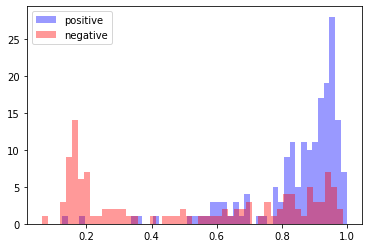

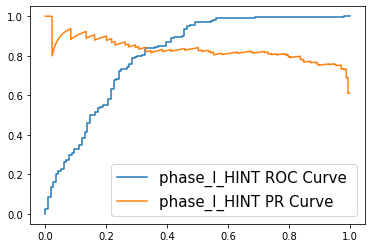

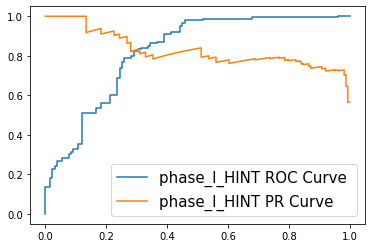

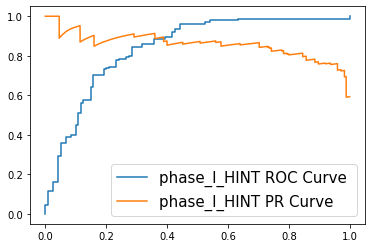

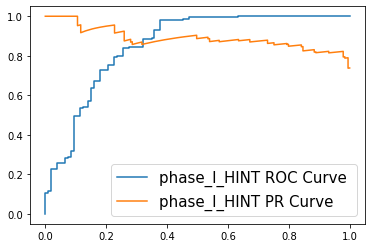

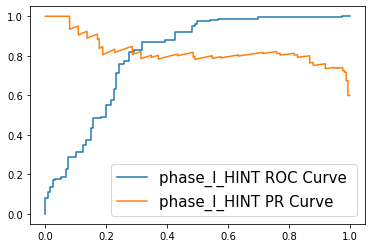

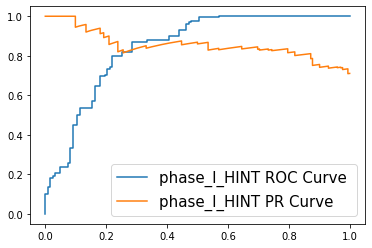

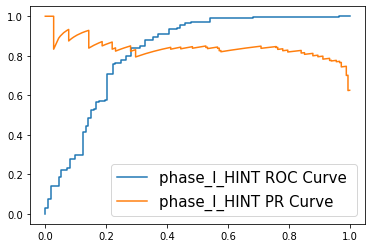

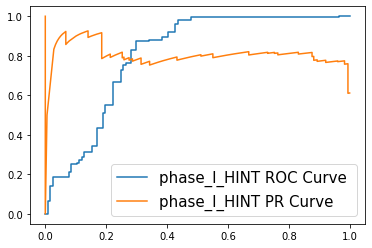

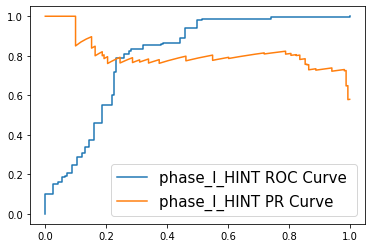

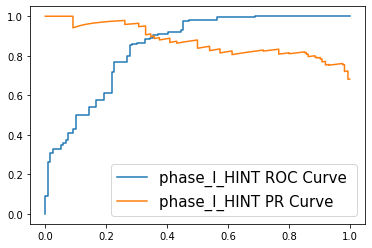

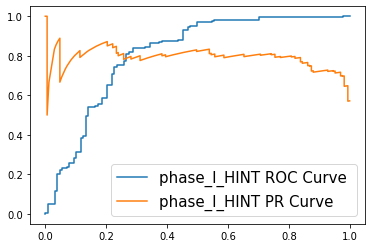

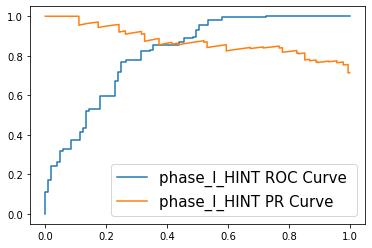

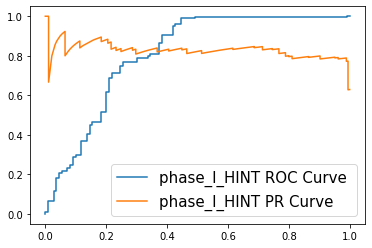

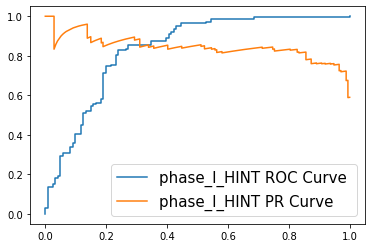

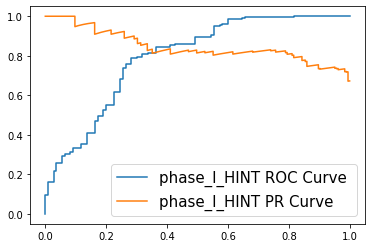

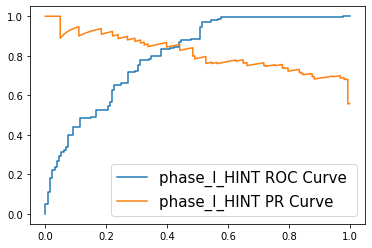

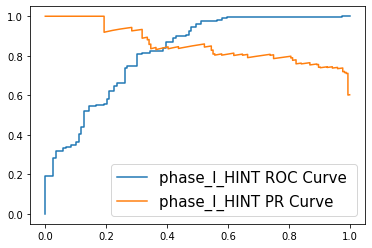

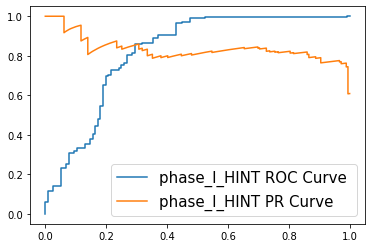

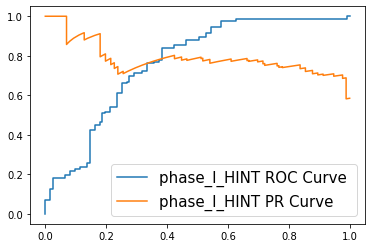

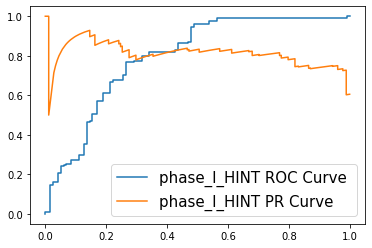

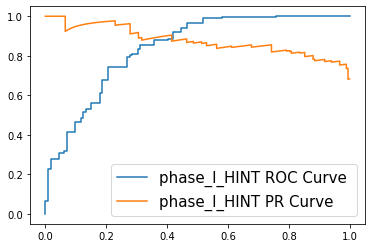

In [6]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			 disease_encoder = gram_model, 
			 protocol_encoder = protocol_model,
			 device = device, 
			 global_embed_size = 50, 
			 highway_num_layer = 2,
			 prefix_name = base_name, 
			 gnn_hidden_size = 50,  
			 epoch = 5,
			 lr = 1e-3, 
			 weight_decay = 0, 
			)
	model.init_pretrain(admet_model)
	model.learn(train_loader, valid_loader, test_loader)
	model.bootstrap_test(test_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)